In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean

Alpha_Q 本身是一個risk aversion parameter，意思是指，在此風險趨避下之投資人，購買本金融商品無異於投資無風險資產(bond)，Alpha_Q愈大代表風險趨避程度愈高的投資人都願意購買本產品，本產品愈佳。而Alpha_Q經過 exp(-alpha_q轉換後)，原本愈大者反而會愈小，故Q measure愈小的金融資產愈好。

# 讀取excess return

In [16]:
df = pd.read_csv('/Users/Kang/Desktop/CSVs/Monthly Return de_rf.csv', index_col = 0)
df = df.set_index(pd.to_datetime(df.index))
df.head()

,ADRD,ADRU,DAX,DBEU,DBEZ,DBGR,DBUK,DDEZ,DEZU,DFE,...,JPEU,NORW,OEUR,PGAL,RFEU,SCID,SMEZ,UPV,VGK,WBIA
2016-05-31,-0.003838,-0.005852,-0.015442,0.017092,0.024795,0.020995,0.002311,-0.002638,0.002200,0.017434,...,-0.002133,-0.026149,-0.010121,-0.018834,-0.009161,0.002573,-0.005323,-0.009747,-0.005388,0.028366
2016-06-30,-0.017256,-0.033027,-0.052719,-0.010927,-0.054382,-0.049542,0.044731,0.008230,-0.073274,-0.100077,...,-0.028053,-0.008902,0.004105,-0.068689,-0.038592,-0.060459,-0.089324,-0.110843,-0.041131,-0.010399
2016-07-29,0.035478,0.041089,0.065219,0.031372,0.044201,0.060814,0.025423,-0.048310,0.016010,0.063473,...,0.012182,-0.005153,0.011269,0.066538,0.049177,0.038579,0.061223,0.074053,0.034319,0.042847
2016-08-31,0.000471,-0.004047,0.022403,0.010925,0.013302,0.024819,0.017817,0.038996,0.064342,0.004821,...,0.012601,0.004269,-0.005600,0.003464,-0.004776,0.010147,0.010377,0.019274,0.006314,-0.013131
2016-09-30,0.003462,-0.006196,0.000304,0.006136,0.003513,-0.003478,0.021697,0.012979,-0.028668,0.017824,...,0.014043,0.061438,-0.007159,-0.019336,0.018470,0.006525,0.021922,0.009733,0.007387,-0.017634


# 寫好要逼近的式子，以及逼近方法

In [17]:
def Measure_Q(alpha_q, etf):
    result = sum([np.exp(-alpha_q * df[etf].iloc[i]) for i in range(len(df))])
    return result

In [18]:
#先以小尺度找出解在哪兩個數字之間
def find_range(etf, down, up, precis = 0.01):
    for i in np.arange(down, up, precis):
        ans = (Measure_Q(i, etf) - len(df)) * (Measure_Q(i + precis, etf) - len(df))
        if ans < 0:
            result = [i, i + precis]
            break
        elif ans == 0:
            if (Measure_Q(i, etf) - len(df)) == 0:
                result = [i]
            else:
                result = [i + precis]
        else:
            continue
    return result

#再使用兩個數字的平均來快速逼近目標
def Approach(etf, down, up, precis_1 = 0.01, precis_2 = 0.0000001): #precis_1是上一個函式的精準度，precis_2是本函式的精準度
    result =  find_range(etf, down, up, precis_1) 
    if len(result) == 2:
        diff = result[1] - result[0]
        while diff >= precis_2:
            tem = Measure_Q(mean(result), etf) - len(df)
            tem_1 = Measure_Q(result[0], etf) - len(df)
            tem_2 = Measure_Q(result[1], etf) - len(df)
            if tem * tem_1 > 0:
                result[0] = mean(result)
            elif tem * tem_1 == 0:
                result = [mean(result)]
                break
            else:
                result[1] = mean(result)
            diff = result[1] - result[0]
        result = [mean(result)]
    else:
        result = result
    return result[0]

# 把df的column當成df_alpha的index

In [19]:
all_ticker = df.columns.tolist()
df_alpha = pd.DataFrame(index = all_ticker, columns = ['Alpha_Q'])

In [20]:
def not_complete_etf(df_alpha):
    #有幾個ETF的alpha_q不在上一個下屆之內?
    NaN_num = int(df_alpha.isnull().sum(axis=0).values)

    #df_alpha為NaN的index
    equal_nan = df_alpha.isnull()
    NaN_l = df_alpha.index[equal_nan['Alpha_Q']].tolist()

    return NaN_l

In [21]:
#跑非常久
for i in all_ticker:
    try:
        df_alpha.loc[i] = Approach(i, 5, 100, 0.01)
    except:
        pass

uncomplete = not_complete_etf(df_alpha)
    
for i in uncomplete:
    try:
        df_alpha.loc[i] = Approach(i, 0.01, 5, 0.01)
    except:
        pass

uncomplete = not_complete_etf(df_alpha)
    
for i in uncomplete:
    try:
        df_alpha.loc[i] = Approach(i, -2, -20, -0.01)
    except:
        pass

In [22]:
not_complete_etf(df_alpha)

[]

In [23]:
df_alpha['Q_measure'] = [(np.exp(-df_alpha['Alpha_Q'].loc[i])) for i in all_ticker]
df_alpha['Rank'] = df_alpha['Q_measure'].rank(ascending = True) #Q measure最小的是1
df_alpha.sort_values("Rank", inplace = True)
df_alpha.head(10)

,Alpha_Q,Q_measure,Rank
DBEU,20.868,8.652430e-10,1.0
HEWU,19.2394,4.410171e-09,2.0
HEWL,18.2266,1.214208e-08,3.0
DBUK,16.26,8.676975e-08,4.0
HEDJ,15.8236,1.342418e-07,5.0
DBEZ,14.6739,4.238261e-07,6.0
HEZU,14.0154,8.188176e-07,7.0
EUSC,13.5398,1.317475e-06,8.0
HFXE,13.4585,1.428983e-06,9.0
EWL,13.1065,2.032056e-06,10.0


In [24]:
#檢查答案
for i in range(len(df_alpha)):
    print(Measure_Q(df_alpha['Alpha_Q'][df_alpha.index[0]], df_alpha.index[0]))

35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.99999998843958
35.9999999

# 畫圖直接看根大約在哪裡

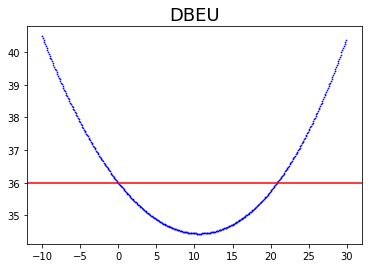

In [26]:
ticker = 'DBEU'
for i in np.arange(-10, 30, 0.1):
    plt.scatter(x= i , y= Measure_Q(i, ticker), color = 'blue', s = 0.5)
    plt.title(ticker, size = 18)
plt.axhline(len(df), color='r')

In [27]:
#df_alpha.to_csv('/Users/Kang/Desktop/Weekly.csv')
#df_alpha.to_csv('/Users/Kang/Desktop/Monthly.csv')